## 1. 安装并导入必要库

In [26]:
# 如果未安装 Detectron2，请取消注释以下行
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html

import os
import cv2
import json
import random
import matplotlib.pyplot as plt
import time

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
3333333333333333333333333333333333333
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

## 2. 注册 COCO2017 数据集

In [2]:
# 修改为你自己的路径
train_json = "/mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_train2017.json"
train_img = "/mnt/workspace/small_coco_train/datasets/coco2017/train2017"
val_json = "/mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_val2017.json"
val_img = "/mnt/workspace/small_coco_train/datasets/coco2017/val2017"

register_coco_instances("my_coco_train", {}, train_json, train_img)
register_coco_instances("my_coco_val", {}, val_json, val_img)

## 3.获取类信息

In [3]:
with open(train_json, "r") as f:
    coco_data = json.load(f)

categories = coco_data["categories"]
class_names = [cat["name"] for cat in categories]

MetadataCatalog.get("my_coco_train").thing_classes = class_names
metadata = MetadataCatalog.get("my_coco_train")
num_classes = len(metadata.thing_classes)

print("类别数量:", num_classes)
print("类别名:", class_names)

类别数量: 80
类别名: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## 4. 配置 Detectron2 模型

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("my_coco_train",)
cfg.DATASETS.TEST = ("my_coco_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.OUTPUT_DIR = "./output_my_coco"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## 5. 开始训练

In [8]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/18 01:26:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## 6. 可视化训练集中的部分样本

[06/18 01:23:26 d2.data.datasets.coco]: Loading /mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_train2017.json takes 19.85 seconds.
[06/18 01:23:28 d2.data.datasets.coco]: Loaded 118287 images in COCO format from /mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_train2017.json


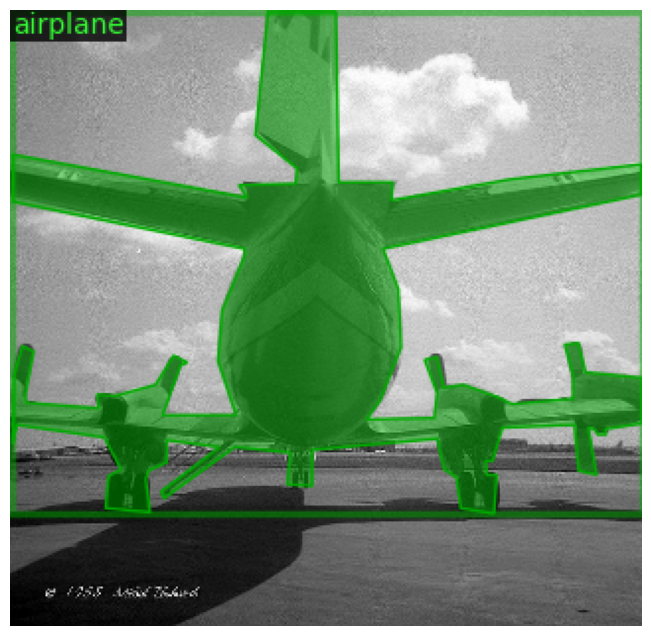

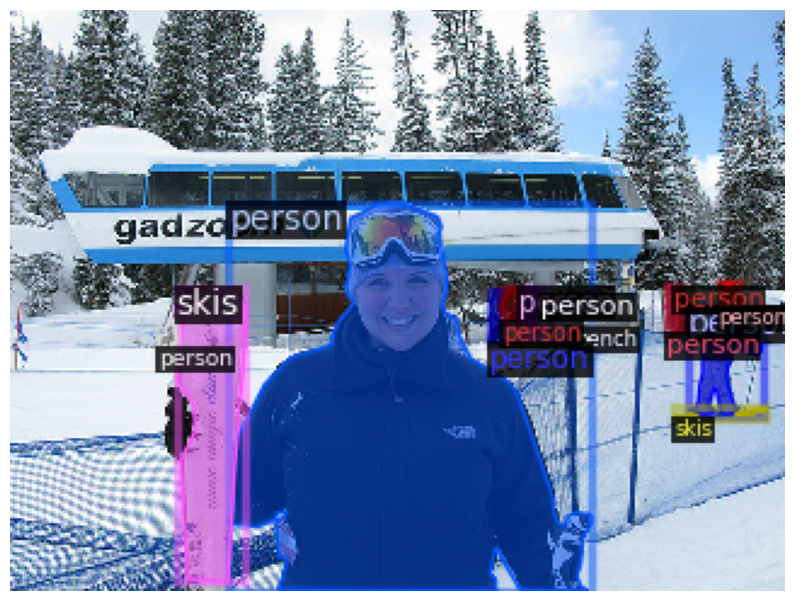

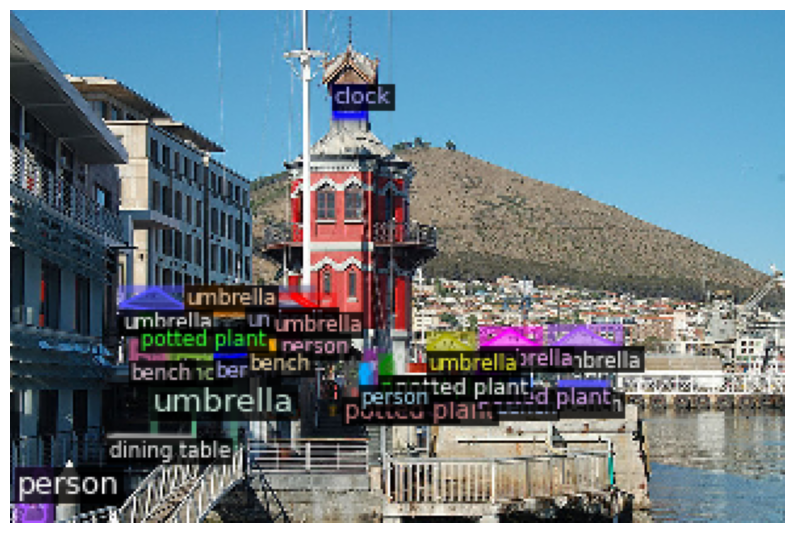

In [5]:
dataset_dicts = DatasetCatalog.get("my_coco_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = v.draw_dataset_dict(d)
    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()


## 7. 使用训练后的模型进行预测并可视化验证集结果

[06/18 01:34:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_my_coco/model_final.pth ...
[06/18 01:34:01 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_val2017.json


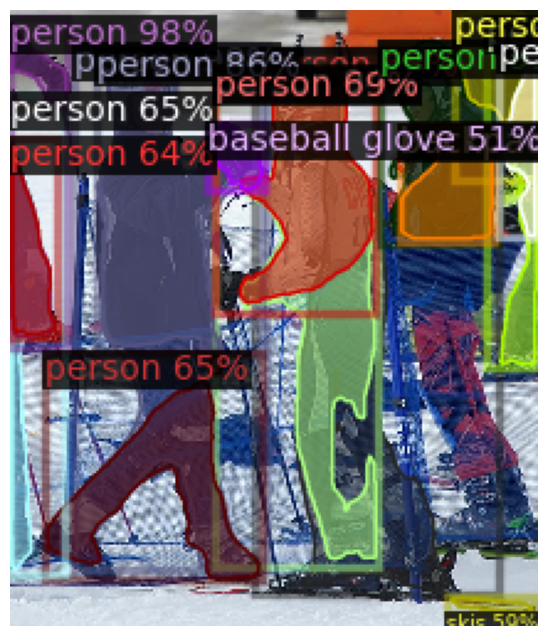

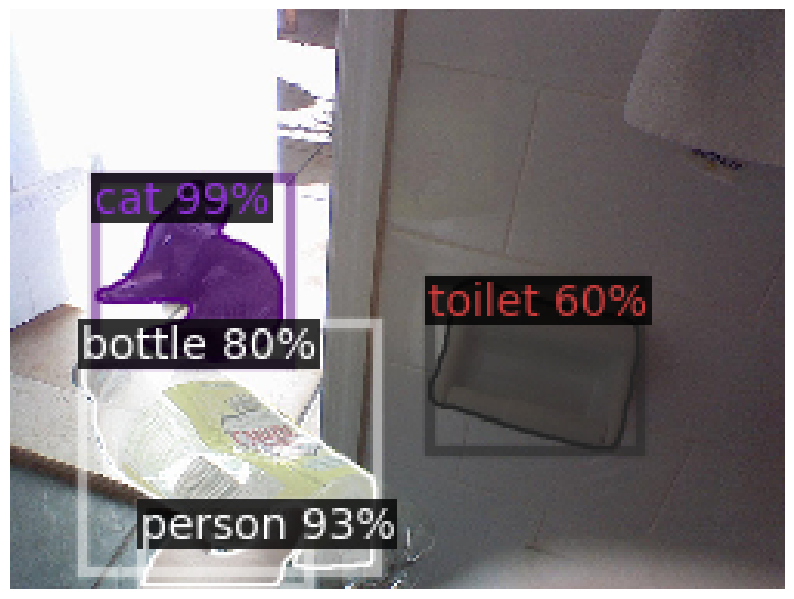

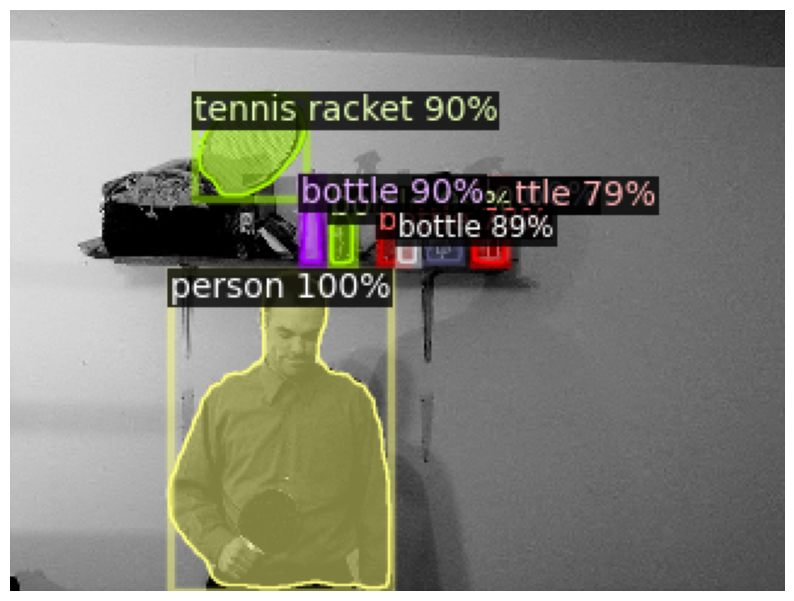

In [11]:
# 加载训练好的模型
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 训练完成后自动保存
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# 验证集可视化
val_dataset_dicts = DatasetCatalog.get("my_coco_val")

for d in random.sample(val_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()


## 使用自己的图片 未在训练集中

推理完成，耗时: 0.34 秒


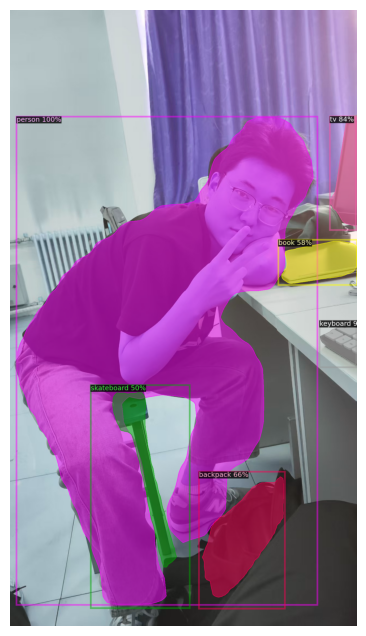

预测完成，结果保存在: datasets/example_2/outputlzy.jpg


In [18]:
photo_parent = "datasets/example_2/"
output_image = "datasets/example_2/output"
img_name = "lzy.jpg"

im = cv2.imread(photo_parent + img_name)
outputs = predictor(im)

start = time.time()
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
end = time.time()
# 推理完成，耗时: 1.91 秒
print(f"推理完成，耗时: {end - start:.2f} 秒")

# 保存结果图
output_path = output_image  + img_name
cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
plt.figure(figsize=(10, 8))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

print(f"预测完成，结果保存在: {output_path}")

推理完成，耗时: 0.75 秒


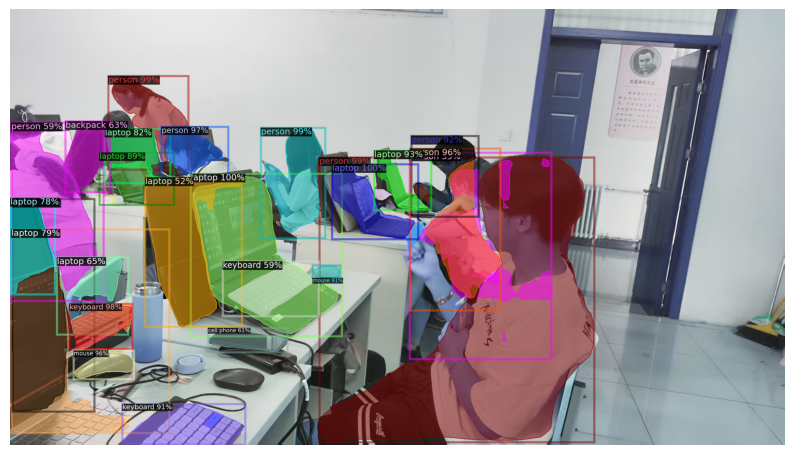

预测完成，结果保存在: datasets/example_2/outputmany_people.jpg


In [19]:
photo_parent = "datasets/example_2/"
output_image = "datasets/example_2/output"
img_name = "many_people.jpg"

im = cv2.imread(photo_parent + img_name)
outputs = predictor(im)

start = time.time()
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
end = time.time()
# 推理完成，耗时: 1.91 秒
print(f"推理完成，耗时: {end - start:.2f} 秒")

# 保存结果图
output_path = output_image  + img_name
cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
plt.figure(figsize=(10, 8))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

print(f"预测完成，结果保存在: {output_path}")

## 8. 使用 TensorBoard 可视化训练曲线（DSW推荐使用图形界面启动

In [10]:
# 推荐：在 DSW 工具栏点击 TensorBoard 图标，填写路径为：
# ./output_my_coco

# 如果想试试 Notebook 内启动（不推荐于DSW中长期运行）
%load_ext tensorboard
%tensorboard --logdir ./output_my_coco
%reload_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7052), started 0:05:41 ago. (Use '!kill 7052' to kill it.)

## 评估模型的效果

WARNING [06/18 01:47:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/18 01:47:19 d2.data.datasets.coco]: Loading /mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_val2017.json takes 1.21 seconds.
[06/18 01:47:19 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /mnt/workspace/small_coco_train/datasets/coco2017/annotations/instances_val2017.json
[06/18 01:47:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/18 01:47:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/18 01:47:19 d2.data.common]: Serializing 5000 elements to byte tensors and concatenating them all ...
[06/18 01:47:19 d2.data.common]: Serialized dataset takes 19.27 MiB
[06/18 01:47:19 d2.evaluation.evaluator]: 

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


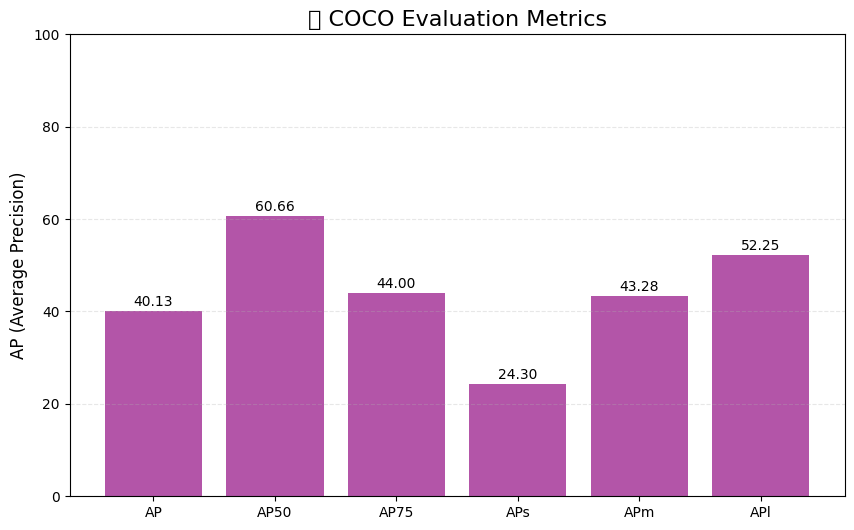

In [20]:
import matplotlib.pyplot as plt
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# 创建 evaluator
evaluator = COCOEvaluator("my_coco_val", cfg, False, output_dir=cfg.OUTPUT_DIR)

# 构建验证集的数据加载器
val_loader = build_detection_test_loader(cfg, "my_coco_val")

# 执行评估并输出结果
eval_results = inference_on_dataset(trainer.model, val_loader, evaluator)

# 优雅输出
import pprint
print("📊 模型评估结果:")
pprint.pprint(eval_results)


# 1. 提取需要展示的 AP 指标
coco_results = eval_results["bbox"]  # 或 "segm"，根据你训练的类型
ap_keys = ["AP", "AP50", "AP75", "APs", "APm", "APl"]
ap_values = [coco_results[k] for k in ap_keys]

# 2. 绘图展示
plt.figure(figsize=(10, 6))
bars = plt.bar(ap_keys, ap_values, color="#A02B93", alpha=0.8)

# 3. 在条形图上添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom')

plt.title("📊 COCO Evaluation Metrics", fontsize=16)
plt.ylabel("AP (Average Precision)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


## 模型 E-R 曲线

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=24.63s).
Accumulating evaluation results...
DONE (t=4.22s).


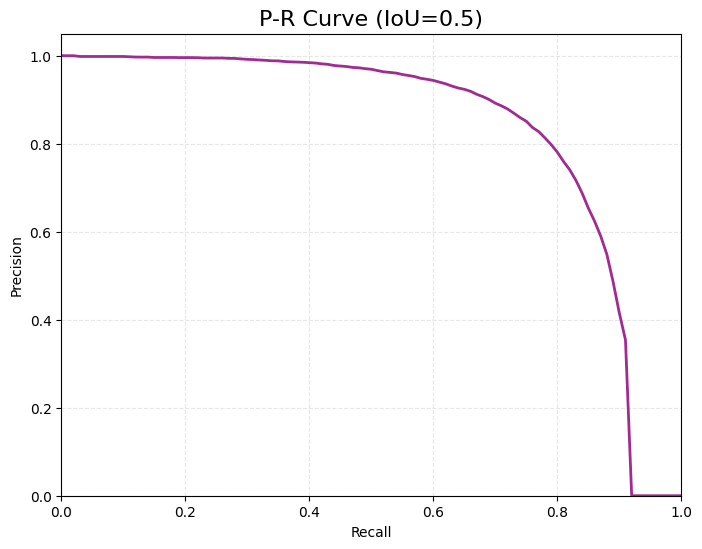

In [24]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import numpy as np

# 1. 加载 GT 和预测结果（COCO 格式）
coco_gt = COCO("datasets/coco2017/annotations/instances_val2017.json")  # eg: "datasets/my_coco_val.json"
coco_dt = coco_gt.loadRes(cfg.OUTPUT_DIR + "/coco_instances_results.json")

# 2. 初始化评估器
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()

# 3. 提取 P-R 曲线数据（IoU=0.5）
iou_index = np.where(np.isclose(coco_eval.params.iouThrs, 0.5))[0][0]
precision = coco_eval.eval['precision']  # shape: [T, R, K, A, M]
# 只取第一个类别（K=0），area=all，maxDets=100
pr_curve = precision[iou_index, :, 0, 0, 2]

recalls = coco_eval.params.recThrs
valid = pr_curve > -1

# 4. 绘图
plt.figure(figsize=(8, 6))
plt.plot(recalls[valid], pr_curve[valid], color="#A02B93", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("P-R Curve (IoU=0.5)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(0, 1.0)
plt.show()


## 绘制多个 IoU 阈值下的 P-R 曲线
COCO评估会在多个 IoU 阈值（0.5~0.95）上评估，你可以画多条曲线，方便观察模型在不同严格度下的表现差异。

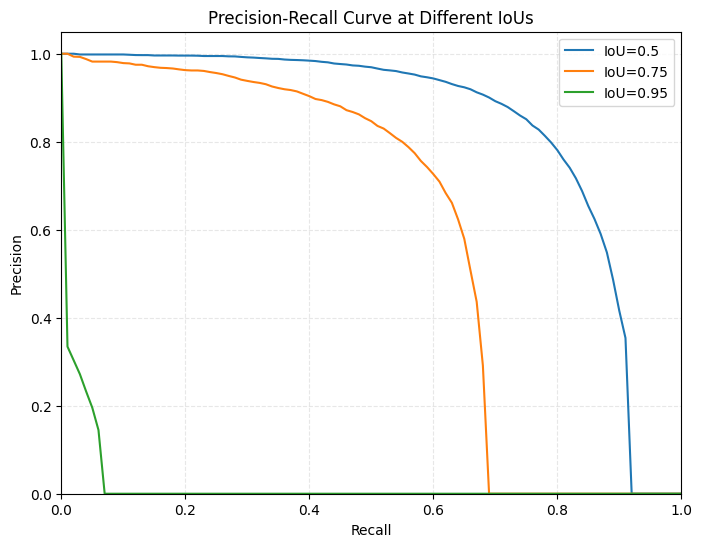

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ious_to_plot = [0.5, 0.75, 0.95]  # 选几个典型阈值

plt.figure(figsize=(8, 6))
for iou_th in ious_to_plot:
    iou_index = np.where(np.isclose(coco_eval.params.iouThrs, iou_th))[0][0]
    pr_curve = precision[iou_index, :, 0, 0, 2]
    recalls = coco_eval.params.recThrs
    valid = pr_curve > -1
    plt.plot(recalls[valid], pr_curve[valid], label=f"IoU={iou_th}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve at Different IoUs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(0, 1.0)
plt.show()
